In [34]:
# alap beállítás és modulbetöltés
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [35]:
# általános deriváló függvény tömbökön működik
# a széleken egy oldali deriválttal, máshol centrális deriválttal közelít

def deriv(xx_tab, ff_tab):  # it 'xx' az általános 'x' változót jelöli, nem az 'x' helykoordinátát!
    N=xx_tab.shape[0]   # a tömb első dimenziója; hibakezelés nincs
    dff_dxx=np.zeros(N, np.float64)  # a deriváltak tömbje
    for i in range(N):
        if i==0:        # bal széle
            deriv=(ff_tab[1]-ff_tab[0])/(xx_tab[1]-xx_tab[0])
        elif i==N-1:    # jobb széle
            deriv=(ff_tab[N-1]-ff_tab[N-2])/(xx_tab[N-1]-xx_tab[N-2])
        else:          # közepe
            deriv=(ff_tab[i+1]-ff_tab[i-1])/(xx_tab[i+1]-xx_tab[i-1])
        dff_dxx[i]=deriv
    return(dff_dxx)
            

In [36]:
# numerikus integráló függvény

def integral(xx_tab, ff_tab, F0=0.0):
    N=xx_tab.shape[0]   # a tömb első dimenziója; hibakezelés nincs
    intff=np.zeros(N, np.float64)  # az integrál értékek tömbje
    intff[0]=F0
    for i in range(1,N):
        intff[i]=intff[i-1]+(xx_tab[i]-xx_tab[i-1])*(ff_tab[i]+ff_tab[i-1])/2.0
    return(intff)

[0.003 0.016 0.019 0.026 0.037 0.046 0.062 0.066 0.093 0.095]


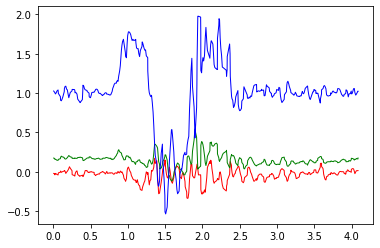

In [67]:
# beolvasunk egy adatfájlt
# skip_header: fejléc sorok átugrása
data=np.genfromtxt("gyors-ugras-1.csv", delimiter=";", skip_header=1)  

# átpakoljuk megfelelő tömbökbe
t_tab=data[:,0]
ax_tab=data[:,1]
ay_tab=data[:,2]
az_tab=data[:,3]

# csak az ellenőrzés kedvéért kicsiben kiplottoljuk
plt.plot(t_tab, ax_tab, linewidth=1, color="red")
plt.plot(t_tab, ay_tab, linewidth=1, color="green")
plt.plot(t_tab, az_tab, linewidth=1, color="blue")

print(t_tab[:10])

In [68]:
# kipróbáljuk az egyik irányban a számolást
# a megfelelő irányt másoljuk át a_tab -ba:
a_tab=az_tab.copy()

v_tab=integral(t_tab, a_tab, 0.0)  # feltesszük, hogy 0 a kezdő sebesség
x_tab=integral(t_tab, v_tab, 0.0) # feltesszük, hogy 0 a kezdő hely

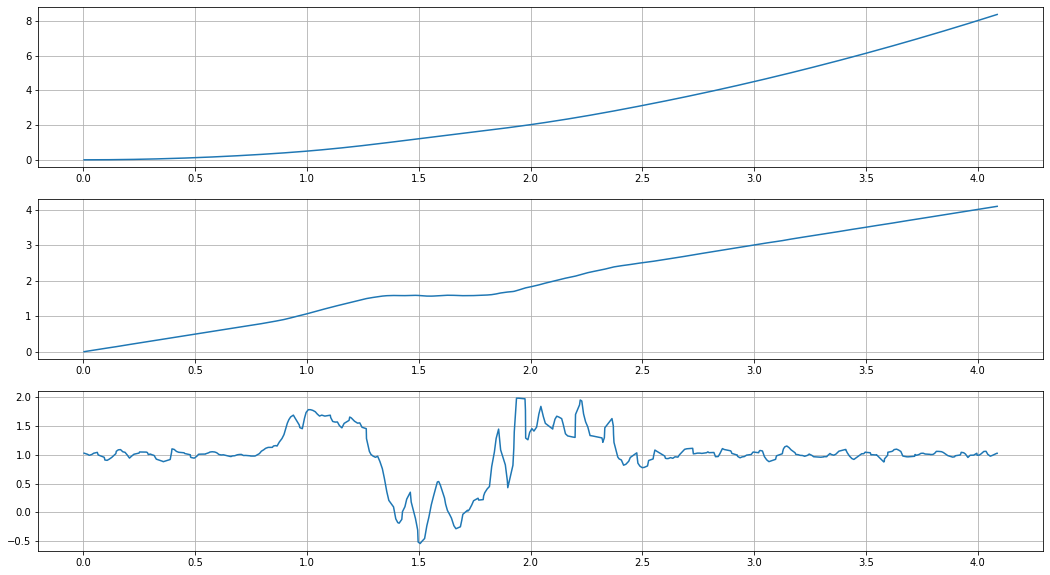

In [69]:
# Most megjelenítjük
fig=plt.figure(figsize=(18,10))  # nagyobb rajzméret
ax1=fig.add_subplot(311) # három rész-grafikon
ax2=fig.add_subplot(312)
ax3=fig.add_subplot(313)
ax1.plot(t_tab, x_tab) # az elsőbe az x(t)
ax2.plot(t_tab, v_tab) # a másodikba a v(t)
ax3.plot(t_tab, a_tab) # a harmadikba az a(t)
ax1.grid()
ax2.grid()
ax3.grid()

In [70]:
# nem jó! szisztematikus hiba
# 1) alappont elcsúszhatott:
print(a_tab[:5])
print(a_tab[-5:])

[1.0254 1.0088 1.0049 0.9883 1.002 ]
[1.0049 0.9736 0.9863 1.0244 1.0235]


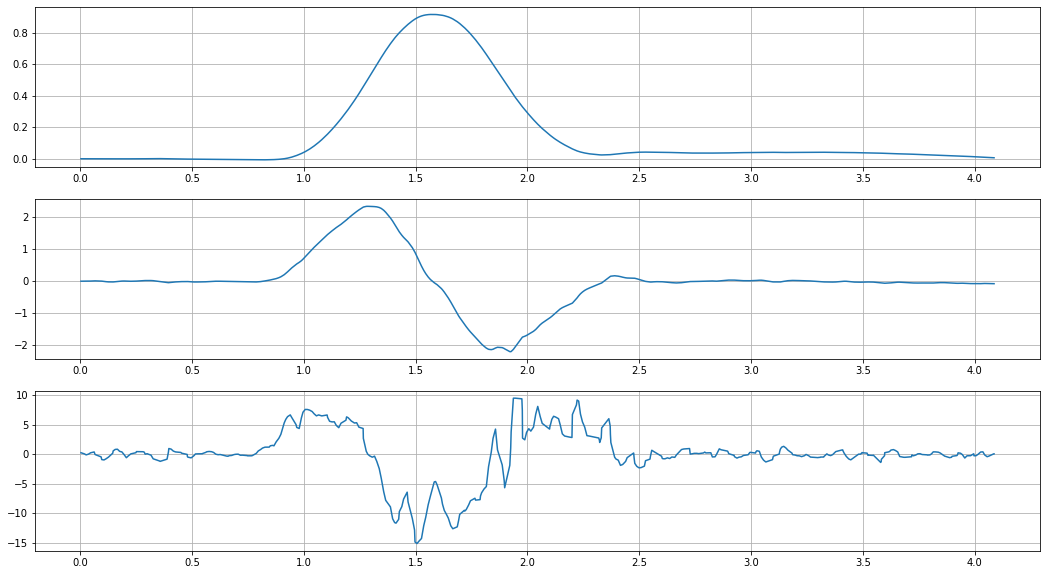

In [77]:
# nullpont-elcsúszás korrekció:
a_kezd=a_tab[:50].mean()
a_veg=a_tab[-50:].mean()

a_shift=a_kezd+(a_veg-a_kezd)*(t_tab-t_tab[0])/(t_tab[-1]-t_tab[0])
# ad-hoc korrekció: állandó alappont-elcsúszást próbál korrigálni
# tekergessük úgy, hogy a végén a sebesség 0 legyen, ha tényleg így volt
a_shift += +0.0001*t_tab

a_corr=(a_tab-a_shift)*9.81
v_tab=integral(t_tab, a_corr, 0.0)  # feltesszük, hogy 0 a kezdő sebesség
x_tab=integral(t_tab, v_tab, 0.0) # feltesszük, hogy 0 a kezdő hely

# Most megjelenítjük
fig=plt.figure(figsize=(18,10))  # nagyobb rajzméret
ax1=fig.add_subplot(311) # három rész-grafikon
ax2=fig.add_subplot(312)
ax3=fig.add_subplot(313)
ax1.plot(t_tab, x_tab) # az elsőbe az x(t)
ax2.plot(t_tab, v_tab) # a másodikba a v(t)
ax3.plot(t_tab, a_corr) # a harmadikba az a(t)
ax1.grid()
ax2.grid()
ax3.grid()

In [78]:
# ugyanez zajszűréssel

In [79]:
import scipy
from scipy import interpolate   # interolálás: mérési adatok egyenletes közű rácsra való vetítése
from scipy.signal import savgol_filter   # zajszűrés. vannak jobb módszerek is, de ezt könnyű használni

In [80]:
# átinterpolálunk egy egyenletes közű rácsra
tstart=t_tab[0]
tend=t_tab[-1]

dt_new=0.01  # új delta t
N_new=int((tend-tstart)/dt_new)+1

t_tab_new=np.linspace(tstart, tend, N_new) # új t értékek tömbje, egyenletesen elosztva dt_new értékenként

#Interpolálás:
a_interpol=interpolate.interp1d(t_tab,a_corr)(t_tab_new)  # a_interpol: gyorsulásértékek az egyenletes rácson

In [81]:
# és most zajszűrünk:
a_filtered=savgol_filter(a_interpol, 45, 3, mode='mirror') # savgol= Savitzky-Golay filter
# a 2. argumentum azt mutatja, hány értékre illesszen polinomot helyről helyre
# a 3. argumentum az illesztett polynom fokszáma

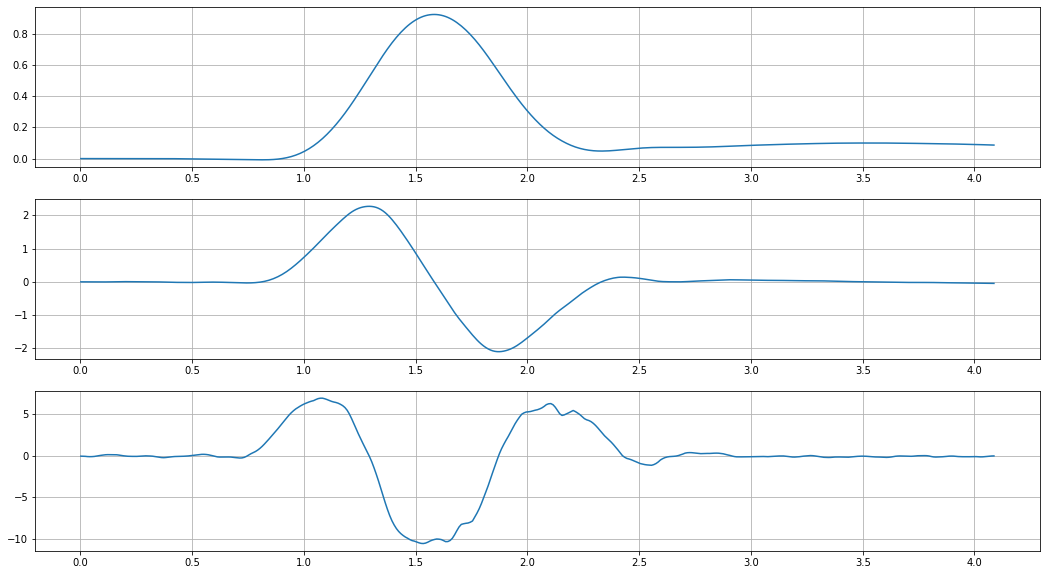

In [82]:

v_tab=integral(t_tab_new, a_filtered, 0.0)  # feltesszük, hogy 0 a kezdő sebesség
x_tab=integral(t_tab_new, v_tab, 0.0) # feltesszük, hogy 0 a kezdő hely

# Most megjelenítjük
fig=plt.figure(figsize=(18,10))  # nagyobb rajzméret
ax1=fig.add_subplot(311) # három rész-grafikon
ax2=fig.add_subplot(312)
ax3=fig.add_subplot(313)
ax1.plot(t_tab_new, x_tab) # az elsőbe az x(t)
ax2.plot(t_tab_new, v_tab) # a másodikba a v(t)
ax3.plot(t_tab_new, a_filtered) # a harmadikba az a(t)
ax1.grid()
ax2.grid()
ax3.grid()